## **Argentina heatwaves**

In [1]:
import sys; sys.path.append('/home/clair/wwa'); from wwa import *

### **Pre-processing**

#### **Construct mask for region of interest**

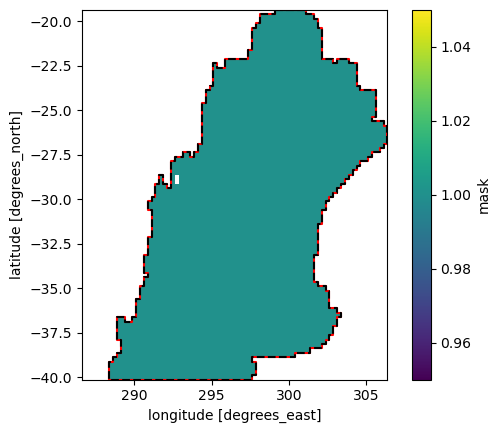

In [14]:
from xrspatial.experimental import polygonize
from shapely.geometry import Polygon

# load ERA5 geopotential data
gp = xr.open_dataset("../90_data/era5_geopotential.nc").squeeze(drop = True).z

# mask off Argentina only
rm = regionmask.defined_regions.natural_earth_v5_0_0.countries_110.mask_3D(gp.longitude, gp.latitude).sel(region = [9,156]).sum("region")

# find areas within Argentina with geopotential < 20000
rm = rm.where(rm).where(gp < 20000).dropna("latitude", "all").dropna("longitude", "all").sel(latitude = slice(None, -40))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## CONVERT TO POLYGON

# define affine transform to correct coordinates
res = 0.25
transform = np.array([res,0,rm.longitude.min().values - res/2,0,-res,rm.latitude.max().values + res/2])

# convert xarray data to polygon, remove any interior holes
rm_poly = polygonize(rm, mask = rm == 1, return_type = "geopandas", transform = transform).set_crs(epsg = "4326")
rm_poly["geometry"] = rm_poly.geometry.apply(lambda p: Polygon(list(p.exterior.coords)))

# extract points from polygon
rm_px = rm_poly["geometry"].apply(lambda p: list(p.exterior.coords)).explode().apply(pd.Series).rename(columns=({0:"x", 1:"y"}))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# SAVE

# save as shapefile, csv & regionmask
rm_poly.to_file("study-region_AR-PY")
rm_px.to_csv("study-region_AR-PY.txt", sep = " ", index = False)
rm.to_netcdf("study-region_AR-PY.nc")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# CONFIRM

# check that these are all capturing the same area
rm.plot()
ax = plt.gcf().axes[0]
rm_poly.boundary.plot(ax = ax, color = "red")
ax.plot(rm_px.x, rm_px.y, color = "k", ls = "--")

#### **ERA5**

In [3]:
# era5 hourly to daily maximum in degC
era5 = xr.open_dataset("data/adaptor.mars.internal-1670941002.8189573-22169-17-a055d329-231c-4c6a-95b3-7fe35064ddb5.nc").sortby("time").mx2t
era5 = convert_units_to(era5, "degC").resample(time = "D").max().mean("expver")

# time series of latest data
sf = gpd.read_file("study-region_AR-PY")
rm = regionmask.mask_3D_geopandas(sf, era5.longitude, era5.latitude).squeeze(drop = True)
era5_2022 = era5.where(rm).dropna("latitude", "all").dropna("longitude", "all").mean(["latitude", "longitude"])

# concatenate latest data with regional download from climate explorer
era5_hist = xr.open_dataset("data/iera5_tmax_daily_e_mask11_5lan_su.nc").tmax.dropna("time", "any")
era5_ts = xr.concat([era5_hist, era5_2022.sel(time = slice(era5_hist.time.max()+1, None))], "time")

era5_ts.to_netcdf("data/era5_AR-PY_daily.nc")

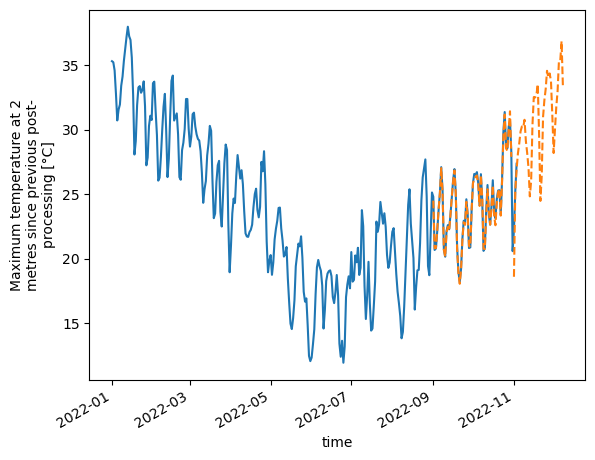

In [13]:
# visual check that regionmask has worked & that my data is equivalent to that downloaded from cx
era5_hist.sel(time = "2022").plot()
era5_2022.plot(ls = "--")

<GeoAxesSubplot:title={'center':'time = 2022-12-08'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

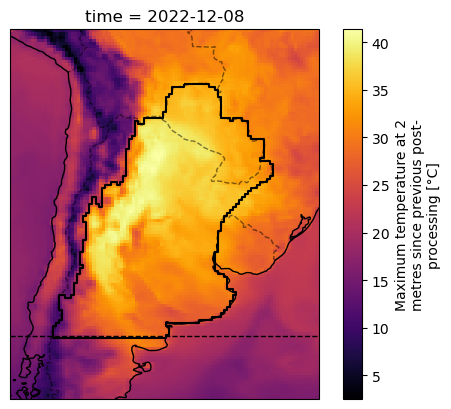

In [14]:
fig, axs = plt.subplots(dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
era5.sel(time = "2022-12-08").plot(ax = axs, cmap = "inferno")
axs.coastlines()
axs.add_feature(cartopy.feature.BORDERS, alpha = 0.5, ls = "--")

axs.axhline(-40, ls = "--", color = "k", lw = 1)

sf.to_crs(axs.projection).boundary.plot(ax = axs, color = "k", lw = 1.5)

#### **CPC**

In [2]:
sf = gpd.read_file("study-region_AR-PY")

cpc = []
for fnm in sorted(glob.glob("../03_cpc/tmax/*.nc")):
    
    tmax = xr.open_dataset(fnm).tmax.sel(lon = slice(285,310), lat = slice(-18,-42)).load()
    rm = regionmask.mask_3D_geopandas(sf, tmax.lon, tmax.lat).squeeze(drop = True)
    
    tmax = tmax.where(rm).dropna("lat", "all").dropna("lon", "all")
    cpc.append(tmax)

cpc_ts = xr.concat(cpc, "time").mean(["lat", "lon"])
cpc_ts.to_netcdf("data/cpc_AR-PY_daily.nc")

#### **Comparison of ERA5 & CPC**

In [80]:
ndays = 7

cpc_ndaymean = xr.open_dataset("data/cpc_AR-PY_daily.nc").tmax.rolling(time = ndays, center = False).mean()
era5_ndaymean = xr.open_dataset("data/era5_AR-PY_daily.nc").tmax.rolling(time = ndays, center = False).mean()

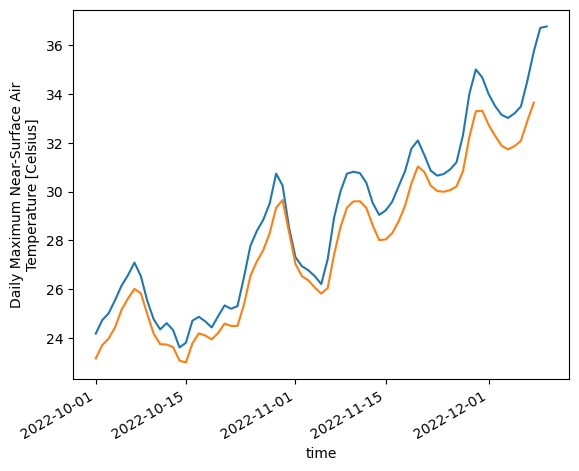

In [81]:
cpc_ndaymean.sel(time = slice("2022-10", None)).plot()
era5_ndaymean.sel(time = slice("2022-10", None)).plot()

Text(0.5, 1.0, 'Difference between CPC & ERA5 7-day maximum: ~1.2°C')

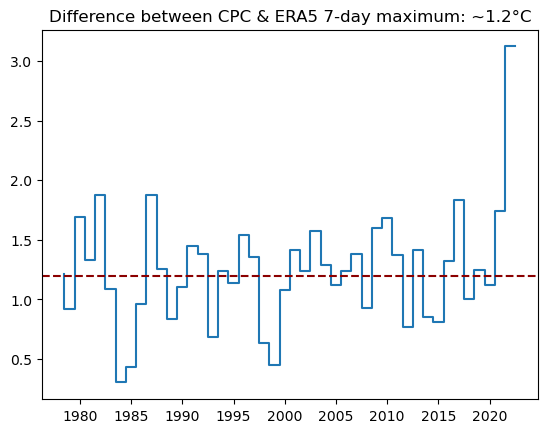

In [88]:
cpc_ann = cpc_ndaymean.resample(time = "AS-JUL").max()
era5_ann = era5_ndaymean.resample(time = "AS-JUL").max()

plt.step(cpc_ann.time, cpc_ann - era5_ann)
plt.axhline((cpc_ann - era5_ann).sel(time = slice(None, "2021")).mean(), color = "darkred", ls = "--")

plt.title("Difference between CPC & ERA5 "+str(ndays)+"-day maximum: ~"+str((cpc_ann - era5_ann).sel(time = slice(None, "2021")).mean().values.round(2))+"°C")

### **Time series of annual maxima**

In [102]:
# compute annual maxima of n-day rolling mean
def nday_max(da, n = 7):
    
    da_max = da.rolling(time = n, center = False).mean().resample(time = "AS-JUL").max()
    da_max = da_max.assign_coords(time = da_max.time.dt.year)
    
    return da_max

In [103]:
era5 = xr.open_dataset("data/era5_AR-PY_daily.nc").tmax
cpc = xr.open_dataset("data/cpc_AR-PY_daily.nc").tmax

era5_7daymax = nday_max(era5, 7)
cpc_7daymax = nday_max(cpc, 7)

if era5.time.max().dt.strftime("%Y-%m-%d") < "2022-12-10":
    
    era5_2022max = era5_7daymax[-1].values.round(4)
    cpc_2022max_adj = (cpc_7daymax[-1].values - 1.2).round(4)
    
    # era5 heatwave value is provisional: replace with adjusted CPC value
    print("Replacing 2022 ERA5 value ("+str(era5_2022max)+") with CPC provisional ("+ str(cpc_2022max_adj)+")")
    era5_7daymax[-1] = cpc_2022max_adj

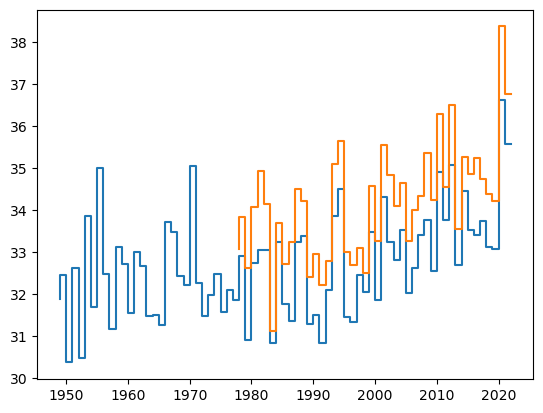

In [104]:
plt.step(era5_7daymax.time,era5_7daymax)
plt.step(cpc_7daymax.time,cpc_7daymax)

In [108]:
csv_fnm = "AR-PY_tasmax-7day_ERA5.dat"

# create extra header lines for upload to Climate Explorer
str1 = "# contact :: ERA5 max temperatures Argentina/Paraguay heatwave 2022, c.barnes22@imperial.ac.uk"
str2 = "# temperature [degC] 7-day max tmax Argentina/Paraguay at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
head = "# year tmax"

! echo "$str1 " > $csv_fnm
! echo "$str2" >> $csv_fnm
! echo "$head" >> $csv_fnm

era5_7daymax.to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

In [109]:
csv_fnm = re.sub("ERA5", "CPC", csv_fnm); str1 = re.sub("ERA5", "CPC", str1); str2 = re.sub("ERA5", "CPC", str2)

! echo "$str1 " > $csv_fnm
! echo "$str2" >> $csv_fnm
! echo "$head" >> $csv_fnm

cpc_7daymax.to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

---
### **Map of event**

In [99]:
cpc = xr.open_dataset("../03_cpc/tmax/tmax.2022.nc").sel(time = slice("2022-07-01", None), lat = slice(-18,-45), lon = slice(360-73,360-52)).tmax

sf = gpd.read_file("study-region_AR-PY").to_crs(cartopy.crs.PlateCarree())
rm = regionmask.mask_3D_geopandas(sf, cpc.lon, cpc.lat).squeeze(drop = True)

# rolling 7-day mean
cpc_7day = cpc.rolling(time = 7, center = False).mean()
hottest_7day = cpc_7day.sel(time = slice("2022-07-01", None)).where(rm).mean(["lat", "lon"]).idxmax().values
print(hottest_7day)

2022-12-10T00:00:00.000000000


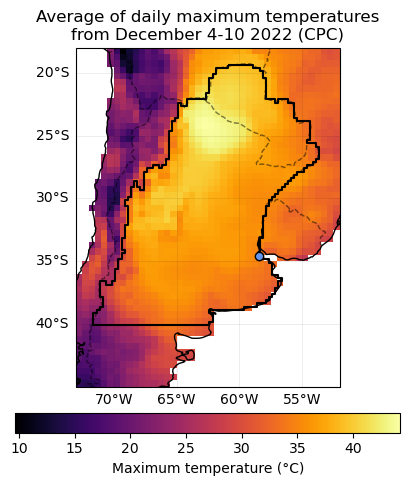

In [101]:
fig, ax = plt.subplots(ncols = 1, dpi = 100, figsize = (5.5,5), subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
cbar_kw = {"location" : "bottom", "fraction" : 0.05, "pad" : 0.07, "label" : "Maximum temperature (°C)"}

cpc_7day.sel(time = hottest_7day).plot(ax = ax, cmap = "inferno", cbar_kwargs = cbar_kw)

ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, ls = "--", color = "k", alpha = 0.5)

sf.boundary.plot(ax = ax, color = "k", lw = 1.5)

ax.plot(*get_latlon("Buenos Aires").values(), marker = "o", mec = "k", color = "cornflowerblue")
# ax.plot(*get_latlon("Cordoba Aero").values(), marker = "o", mec = "k", color = "cornflowerblue")
# ax.plot(*get_latlon("Santiago del Estero").values(), marker = "o", mec = "k", color = "cornflowerblue")
# ax.plot(*get_latlon("Presidencia Roque").values(), marker = "o", mec = "k", color = "cornflowerblue")
# ax.plot(*get_latlon("Neuquen").values(), marker = "o", mec = "k", color = "cornflowerblue")

ax.set_title("Average of daily maximum temperatures\nfrom December 4-10 2022 (CPC)")

ax.xlabels_top = False
ax.ylabels_left = False
ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["left", "bottom"], xlocs = [-70,-65,-60,-55], alpha=0.1)

plt.savefig("event-definition_cpc_7daymax.png")

---
### **Station data**

In [181]:
# load station locations
stations = []
for fnm in glob.glob("data/xgdcnAR*.nc"):
    ds = xr.open_dataset(fnm).dropna("time", "any")
    stations.append([ds.attrs[k] for k in ["station_code", "station_name", "longitude", "latitude"]] + [ds.time.max().dt.strftime("%Y-%m-%d").values])
stations = pd.DataFrame(stations, columns = ["station_code", "station_name", "longitude", "latitude", "last_obs"]).set_index("station_code")
stations["longitude"] = [float(l.split(" ")[1]) for l in stations.longitude]
stations["latitude"] = [float(l.split(" ")[1]) for l in stations.latitude]

In [230]:
ghcn = pd.read_csv("data/ghcn-stations_1213.csv").set_index("DATE")
ghcn_2022 = ghcn.loc[ghcn.index >= "2022-01-01"]

<AxesSubplot:xlabel='DATE'>

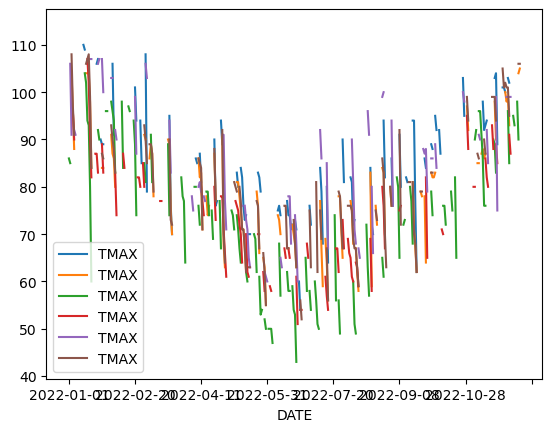

In [241]:
ghcn_2022.loc[ghcn_2022.STATION == "AR000087129"][["TMAX"]].plot(); ax = plt.gcf().axes[0]
ghcn_2022.loc[ghcn_2022.STATION == "AR000087344"][["TMAX"]].plot(ax = ax)
ghcn_2022.loc[ghcn_2022.STATION == "AR000087715"][["TMAX"]].plot(ax = ax)
ghcn_2022.loc[ghcn_2022.STATION == "AR000875850"][["TMAX"]].plot(ax = ax)
ghcn_2022.loc[ghcn_2022.STATION == "ARM00087148"][["TMAX"]].plot(ax = ax)
ghcn_2022.loc[ghcn_2022.STATION == "ARM00087345"][["TMAX"]].plot(ax = ax)

In [200]:
ghcn.loc["AR000087129"][["TMAX"]].index > "2022-01-01"

array([False, False, False, ...,  True,  True,  True])

In [ ]:
fig, axs = plt.subplots(dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
era5_2022.sel(time = "2022-01-02").plot(ax = axs, cmap = "Reds")
axs.coastlines()
axs.add_feature(cartopy.feature.BORDERS)

axs.scatter(stations.longitude, stations.latitude, marker = "x", color = "k")
axs.axhline(-40, ls = "--", color = "k")

# sf.boundary.plot(ax = axs, color = "k", lw = 0.5)